# Project 2 a)

In [51]:
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt 

## project 1 things -- not used so far

In [52]:
# from project1 for ols

import scipy.special # for binomial coefficient
from sklearn.linear_model import LinearRegression , Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# not necc
import pandas as pd

In [53]:
''' generate design matrix without intercept column for flattend x1, x2 '''
def design_no_in(x1f, x2f, degreeplus1):
    n = x1m.size
    # 1. setting up design matrix
    # we work here with intercept column
    # the designmatrix s.t. we have the features 1, x1, x2, x1x2, x1^2, x2^2, ....
    # with max totaldegree 5
    # number of possible monoms up to degree 5 for 2 variables is 2+5 choose 5
    num_of_monoms = scipy.special.binom(degreeplus1 + 1, degreeplus1 -1)
    X = np.zeros((n, int(num_of_monoms))) # afterwards the intercept column is removed
    c = 0
    for i in range(degreeplus1):
        for j in range(degreeplus1 - i):
            X[:,c] = x1f**i * x2f**j
            #print('{} {}'.format(i,j))
            #print(X[:,c])
            #print('x_1^{} * x_2^{}'.format(i,j)) 
            c += 1
    # remove now intercept column
    X = X[:,1:]
    return X

# for OLS k-fold
def design_with_in(x1f, x2f, degreeplus1):
    n = x1f.size
    num_of_monoms = scipy.special.binom(degreeplus1 + 1, degreeplus1 -1)
    X = np.zeros((n, int(num_of_monoms)))
    c = 0
    for i in range(degreeplus1):
        for j in range(degreeplus1 - i):
            X[:,c] = x1f**i * x2f**j
            #print('{} {}'.format(i,j))
            #print(X[:,c])
            #print('x_1^{} * x_2^{}'.format(i,j)) 
            c += 1
    return X

'''
generate data for meshgrid (x1m, x2m) and according y. degree is the maximum degree of the
polynomial represented by the designmatrix
'''
def data(degree, x1m, x2m, y):
    degreeplus1 = degree + 1

    x1m_flat = x1m.flatten()
    x2m_flat = x2m.flatten()
    
    X = design_no_in(x1m_flat, x2m_flat, degreeplus1)
    
    # 2. split the data in test and training data
    X_train, X_test, y_train, y_test = train_test_split(X, y.flatten())
 
    # 3. scaling of training data (by subtracting the mean value of each column)
    X_train_mean = np.mean(X_train, axis=0)
    X_train_scaled = X_train  - X_train_mean

    y_train_mean = np.mean(y_train)
    y_train_scaled = y_train - y_train_mean

    # in order to use beta for test → test has to be scaled by training means
    X_test_scaled = X_test - X_train_mean
    #X_test_scaled = X_test - X_train_mean
    y_test_scaled = y_test - y_train_mean

    return X, X_train, X_test, X_train_scaled, X_train_mean, X_test_scaled, y_train_scaled, y_train_mean, y_train, y_test


def OLS_analysis(maxdegree):
    degrees = np.arange(1,maxdegree + 1)
    num_monoms = int(scipy.special.binom(maxdegree + 2, maxdegree))

    betas = np.zeros((maxdegree, num_monoms)) # for maxdegree = 5: 7 choose 5 is the number of possible monoms up to degree 5 for 2 variables (not -1 because the intercept will be added)
    MSE = np.zeros((maxdegree,2)) # 0.column for train, 1. for test
    R2 = np.zeros((maxdegree,2))
    for degree in degrees:
        print('DEGREE = ' + str(degree))
        X, X_train, X_test, X_train_scaled, X_train_mean, X_test_scaled, y_train_scaled, y_train_mean, y_train, y_test = data(degree, x1m, x2m, y)
        
        beta_lin = np.linalg.inv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ y_train_scaled # without intercept
        intercept = y_train_mean - X_train_mean @ beta_lin
        betas[degree-1] = np.hstack([intercept, beta_lin, np.zeros(( num_monoms -1 - beta_lin.size,))])
    
        #print('beta = {}'.format(betas[degree-1]))
        
        ypredict_train_LR =  X_train_scaled @ beta_lin + y_train_mean
        ypredict_test_LR = X_test_scaled @ beta_lin + y_train_mean
        ypredict_all_LR = X @ beta_lin + y_train_mean
        
        
    
        MSE[degree-1, 0] = mean_squared_error(y_train, ypredict_train_LR)
        MSE[degree-1, 1] = mean_squared_error(y_test, ypredict_test_LR)
        R2[degree-1, 0] = r2_score(y_train, ypredict_train_LR)
        R2[degree-1, 1] = r2_score(y_test, ypredict_test_LR)

        '''

        print("Mean squared error for train: {}".format(mean_squared_error(y_train, ypredict_train_LR)))
        print('R^2 score for train:          {}'.format(r2_score(y_train, ypredict_train_LR)))
        print("Mean squared error for test:  {}".format(mean_squared_error(y_test, ypredict_test_LR)))
        print('R^2 score for test:           {}'.format(r2_score(y_test, ypredict_test_LR)))
            
        print('summary statistics for train prediction LR')
        print(pd.DataFrame(ypredict_train_LR).describe())
        print('summary statistics for test prediction LR')
        print(pd.DataFrame(ypredict_test_LR).describe())
        '''

    return MSE, R2, betas, degrees

In [54]:
def Ridge_analysis(lambd):

    num_monoms = int(scipy.special.binom(maxdegree + 2, maxdegree))
    betas = np.zeros((5, num_monoms)) # for maxdegree = 5: 7 choose 5 is the number of possible monoms up to degree 5 for 2 variables
    MSE = np.zeros((5,2)) # 0.column for train, 1. for test
    R2 = np.zeros((5,2))
    
    degrees = np.arange(1,maxdegree + 1)
    for degree in degrees:
        #print('DEGREE = ' + str(degree))
        X, X_train, X_test, X_train_scaled, X_train_mean, X_test_scaled, y_train_scaled, y_train_mean, y_train, y_test = data(degree, x1m, x2m, y)
        
        # RIDGE REGRESSION:
        beta_rr = np.linalg.inv(X_train_scaled.T @ X_train_scaled + lambd*np.identity(X_train_scaled.shape[1])) @ X_train_scaled.T @ y_train_scaled #without intercept
        intercept = y_train_mean - X_train_mean @ beta_rr
        betas[degree-1] = np.hstack([intercept,  beta_rr, np.zeros(( num_monoms  - 1 - beta_rr.size,))])
                
        #print('beta = {}'.format(beta_rr))
        
        ypredict_train_RR =  X_train_scaled @ beta_rr + y_train_mean
        ypredict_test_RR = X_test_scaled @ beta_rr + y_train_mean
        ypredict_all_RR = X @ beta_rr + y_train_mean

        ''' for sake of understanding the functions of sklearn
        # prediction using sklearn
        RegRidge = Ridge(lambd)
        RegRidge.fit(X_train,y_train)
        ypredictRidge = RegRidge.predict(X_test)
        print('difference of y_pred: true - sklearn, not scaled data (but also no intercept column): {}'.format(ypredict_test_RR - ypredictRidge))

        ridge2 = Ridge(lambd, fit_intercept=False)
        ridge2.fit(X_train_scaled,y_train_scaled)
        y_pred2 = ridge2.predict(X_test_scaled) + y_train_mean
        print('difference of y_pred: true - sklearn, scaled data (and also no intercept column): {}'.format(ypredict_test_RR - y_pred2))
        print('difference of differences = {}'.format(ypredictRidge - y_pred2))
        ''' 

    
        '''
        print("Mean squared error for train: {}".format(mean_squared_error(y_train, ypredict_train_RR)))
        print('R^2 score for train:          {}'.format(r2_score(y_train, ypredict_train_RR)))
        print("Mean squared error for test:  {}".format(mean_squared_error(y_test, ypredict_test_RR)))
        print('R^2 score for test:           {}'.format(r2_score(y_test, ypredict_test_RR)))
        '''
        
        MSE[degree-1, 0] = mean_squared_error(y_train, ypredict_train_RR)
        MSE[degree-1, 1] = mean_squared_error(y_test, ypredict_test_RR)
        R2[degree-1, 0] = r2_score(y_train, ypredict_train_RR)
        R2[degree-1, 1] = r2_score(y_test, ypredict_test_RR)


    return betas, MSE, R2



betas_lam = np.zeros((5, int(scipy.special.binom(maxdegree + 2, maxdegree)), num_lambdas))
MSE_lam = np.zeros((5,2, num_lambdas))
R2_lam = np.zeros((5,2, num_lambdas))

NameError: name 'maxdegree' is not defined

## week 41 - exercise functions

I consider the function $f(x) = 1 - 2x + 1/3x^2$.

In [55]:
np.random.seed(1)
n = 100
# Make data set.
x = np.linspace(-1,6, n).reshape(-1, 1)
y = 1 - 2*x +1/3*x**2

X = np.c_[np.ones((n,1)),x, x**2]
#yr = 1 - 2*x +1/3*x**2 + (np.random.rand(n,1) - 0.5)

<function matplotlib.pyplot.show(close=None, block=None)>

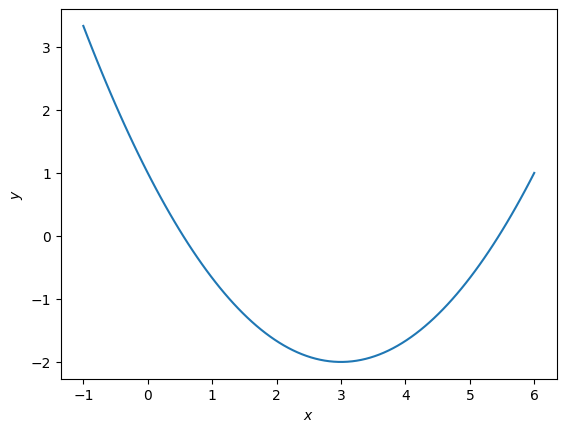

In [56]:
plt.plot(x,y)
#plt.plot(x,yr,'o')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show

### Gradient descent / steepest descent
First we consider OLS regression, and thus the function that we want to minimize is $$C(\beta) = 1/n \| X\beta - y \|^2_2 = 1/n (X\beta - y)^\top (X\beta - y) = 1/n \beta^\top X^\top X \beta - 2/n \beta^\top X^\top y + 1/n y^\top y$$
So we know that the gradient w.r.t $\beta$ is $$\nabla C(\beta) = 2/n X^\top (X\beta - y)$$
Since the second derivative is $2/n X^\top X$, which is positive semidefinite, we know that $C(\beta)$ is convex.

In [57]:
def gradient_C_MSE(X,y,beta, method='OLS', lamb=0):
    n = y.size
    if method == 'OLS':
        return 2.0/n * X.T @(X@ beta -y)
    if method == 'RIDGE':
        return 2.0/n * X.T @(X@ beta -y) + 2.0* lamb*beta
    
    

''' simple gradient descent'''
''' if gamma = 0 → the optimum 
    gamma by hessian is chosen, else the gamma value'''
def gd_gamma(X,y,f_gradient, niter=1000, gamma=0, method='OLS', lamb=0):
    if method not in ['OLS', 'RIDGE']:
        raise ValueError('no valid method chosen.')
        
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta

    if not gamma:
        # considering optimum stepsize wrt deeplearning
        if method == 'OLS':
            H = (2.0/n)* X.T @ X
        if method =='RIDGE':
            H = (2.0/n)* X.T @ X + 2.0*lamb

        # Get the eigenvalues
        EigValues, EigVectors = np.linalg.eig(H)
        gamma = 1.0/np.max(EigValues) # optimum stepssize wrt to deeplearningbook.org page 86
    
    for iter in range(niter):
        xk -= gamma*f_gradient(X,y,xk, method, lamb)
    beta_GD = xk
    return beta_GD



### plain GD with momentum

In [58]:
def gd_momentum(X,y,f_grad, method='OLS', lamb=0, Niter=1000, gamma=0, moment=0.3):
    if method not in ['OLS', 'RIDGE']:
        raise ValueError('no valid method chosen.')

    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta
    
    if not gamma:
        # considering optimum stepsize wrt deeplearning
        if method == 'OLS':
            H = (2.0/n)* X.T @ X
        if method =='RIDGE':
            H = (2.0/n)* X.T @ X + 2.0*lamb

        # Get the eigenvalues
        EigValues, EigVectors = np.linalg.eig(H)
        gamma = 1.0/np.max(EigValues) # optimum stepssize wrt to deeplearningbook.org page 86

    
    change=0.0
    
    for iter in range(Niter):
        change = gamma*f_gradient(X,y,xk, method, lamb) + moment*change
        xk -= change
    beta_GD = xk
    return beta_GD

### stochastic GD with time decay scaling (or gama)

In [88]:
''' OLD which  I GUESS is incorrect, but somehow worked in lectures with this ''' 
def sum_c_i(X_sub, beta, y_sub,n, method='OLS', lamb=0): # Xsub is a X from which rows are deleted, same for y_sub
    if method == 'OLS':
        return X_sub.T @ ((X_sub @ beta) - y_sub) *2/n
    if method == 'RIDGE':
        return X_sub.T @ ((X_sub @ beta) - y_sub) *2/n  + 2*lamb*y_sub.size/n


''' What I think would be more correct 
# Assuming that we do not minimize MSE but RSS for OLS and RSS+ lambbeta^Tbeta
def sum_c_i(X_sub, beta, y_sub,n, method='OLS', lamb=0): # Xsub is a X from which rows are deleted, same for y_sub
    if method == 'OLS':
        return X_sub.T @ ((X_sub @ beta) - y_sub) *2
    if method == 'RIDGE':
        return X_sub.T @ ((X_sub @ beta) - y_sub) *2  + 2*lamb

    #TODO IWIE MACHEN ALLE DIESES AVERAGINING MIT 1/M ABER KA WIESO
'''
def gamma_timedecay(t,t0,t1):
    if t0 <= 0 or t1 <= 0:
        raise ValueError("t0 or t1 <= 0")
    return t0/(t+t1)


In [60]:
def sgd(X,y,sum_c_i, method='OLS',lamb=0, n_epochs=50, M=5, t0=1,t1=10, gam = 0):
    if method not in ['OLS', 'RIDGE']:
        raise ValueError('no valid method chosen.')
    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta


    m = int(y.size/M) #number of minibatches

    for e in range(n_epochs):
        shuff = np.random.choice(X.shape[0], X.shape[0], False)
        X_shuff = X[shuff]
        y_shuff = y[shuff]
        for i in range(m):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient = sum_c_i(Xi, xk, yi,n, method, lamb) # 1/M
            if gam:
                gamma = gam

            else: 
                gamma = gamma_timedecay(e*m + i,t0,t1)
            xk = xk - gamma*gradient
    return xk

### stochastic gd + time decay scaling (or gamma) + momentum

In [61]:
# note by setting momentum = 0, we have the old sgd
def sgd_momentum(X,y,sum_c_i, method='OLS', lamb=0, n_epochs=50, M=5, t0=1,t1=10, gam=0, momentum = 0.9):
    if method not in ['OLS', 'RIDGE']:
        raise ValueError('no valid method chosen.')
    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta

    if not gam:
        gamma_f = gamma_timedecay
    else:
        gamma_f = lambda x, y, z: gam

    m = int(y.size/M) #number of minibatches
    change = 0
    for e in range(n_epochs):
        shuff = np.random.choice(X.shape[0], X.shape[0], False)
        X_shuff = X[shuff]
        y_shuff = y[shuff]

        for i in range(m):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient =  sum_c_i(Xi, xk, yi,n, method, lamb)

            gamma = gamma_f(e*m + i,t0,t1)
            change = gamma*gradient + change*momentum
            xk = xk - change

    return xk

### adagrad with stochastic gd with & without momentum

In [62]:
def sgd_momentum_adagrad(X,y,sum_c_i, method='OLS', lamb=0, n_epochs=50, M=5, gamma=0.001, momentum = 0.9, delta=1e-8):
    if method not in ['OLS', 'RIDGE']:
        raise ValueError('no valid method chosen.')
    n = y.size
    if M > n:
        raise ValueError("can't take Minibatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta

    m = int(y.size/M) #number of minibatches
    change = 0.0
    for e in range(n_epochs):
        shuff = np.random.choice(X.shape[0], X.shape[0], False)
        X_shuff = X[shuff]
        y_shuff = y[shuff]

        Giter = 0.0
        for i in range(m):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient =  sum_c_i(Xi, xk, yi,n,method,lamb)
            Giter += gradient*gradient
            change = gamma*gradient/(delta + np.sqrt(Giter)) + change*momentum
            xk = xk - change

    return xk

### RMS propagation (Stochastic gd)

In [63]:
def sgd_rmsprop(X,y,sum_c_i, method='OLS', lamb=0, n_epochs=50, M=5, gamma=0.001, momentum = 0.9, delta=1e-8):
    if method not in ['OLS', 'RIDGE']:
        raise ValueError('no valid method chosen.')

    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta


    m = int(y.size/M) #number of minibatches
    change = 0.0
    for e in range(n_epochs):
        shuff = np.random.choice(X.shape[0], X.shape[0], False)
        X_shuff = X[shuff]
        y_shuff = y[shuff]

        for i in range(m):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient =  sum_c_i(Xi, xk, yi,n, method, lamb)
            Giter = gradient*gradient
            change = (1- momentum)*Giter + change*momentum
            xk = xk - gamma*gradient/(np.sqrt(change) + delta)

    return xk

### ADAM stochastic

In [64]:
def sgd_adam(X,y,sum_c_i, method='OLS', lamb=0, n_epochs=50, M=5, gamma=0.001, momentum = 0.9, secmomentum = 0.99, delta=1e-8):
    if method not in ['OLS', 'RIDGE']:
        raise ValueError('no valid method chosen.')

    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta
    m = int(y.size/M) #number of minibatches
    
    
    for e in range(n_epochs):
        shuff = np.random.choice(X.shape[0], X.shape[0], False)
        X_shuff = X[shuff]
        y_shuff = y[shuff]

        mk = 0.0
        sk= 0.0
        for k in range(1, m+1):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient =  sum_c_i(Xi, xk, yi,n, method, lamb)
            Giter = gradient*gradient
            mk = ((1- momentum)*gradient + momentum*mk)/(1- momentum**k)
            sk = ((1- secmomentum)*Giter + secmomentum*sk)/(1-secmomentum**k)
            xk = xk - gamma*mk/(np.sqrt(sk) + delta)

    return xk

## replace analytical gradient using autograd

For the non stochastic variants we can use

In [116]:
# MSE for OLS and MSE+ lambda * beta^Tbeta for RIDGE ( but this is not the TRUE criterion we have for ridge minimiation !!!!!)
def cost(X,y,beta, method='OLS',lamb=0):
    if method == 'OLS':
        return np.sum((y-X @ beta)**2)/ X.shape[0]    #(X@ beta -y).T @ (X @ beta - y) 
    elif method == 'RIDGE':
        return np.sum((y-X @ beta)**2)/ X.shape[0] + np.sum(beta**2) #(X@ beta -y).T @ (X @ beta - y) + lamb * beta.T @ beta

And then the gradient with respect to beta is given by the following:

In [123]:
# Gradient function
cost_grad = grad(cost, 2)

# e.g.
X = np.array([[1,1,1,1], [1,2,3,4], [2,4,4,2], [3,3,3,3]])
y = np.array([1,2,1,1])
beta = np.array([0.5, 1, 2, 1]).reshape(-1,1)
lamb = 10
method = 'RIDGE'
#method = 'OLS'
cost_grad(X,y,beta, method, lamb)

array([[158.5],
       [237. ],
       [261.5],
       [227. ]])

And for the stochastic gradients consider the following:

In order to get $\nabla C(\beta) = \sum_{i=1}^n \nabla c_i(x_i, \beta)$

For OLS (with lambda = 0) and RIDGE this $c_i(x_i)$ is simply $$
\frac{1}{n}(x_i \beta - y_i)^2 + \frac{1}{n}\lambda  \sum_{j=1}^p \beta_j^2$$
So the sum of some $c_i(x_i)$ for $i \in I$ is $$\sum_{i \in I} c_i(x_i) = \frac{1}{n} \Big(\sum_{i \in I} (x_i \beta - y_i)^2 \Big) + \frac{|I|}{n}\lambda  \sum_{j=1}^p \beta_j^2 = \frac{1}{n} \Big(  |I| \lambda  \sum_{j=1}^p \beta_j^2 +   \sum_{i \in I} (x_i \beta - y_i)^2\Big)$$

In [118]:
# so that if X_sub = X ... then have cost
def subset_cost(X_sub,y_sub,beta, n, method='OLS', lamb=0):
    if method == 'OLS':
        return np.sum((y_sub-X_sub @ beta)**2)/ n  #(X@ beta -y).T @ (X @ beta - y) 
    elif method == 'RIDGE':
        return 1/n * (np.sum((y_sub-X_sub @ beta)**2) + X_sub.shape[0] * np.sum(beta**2))

In [125]:
# Gradient function
subset_cost_grad = grad(subset_cost, 2)

# e.g. 
n = X.shape[0]
subset_cost_grad(X,y,beta,n, method, lamb)

array([[158.5],
       [237. ],
       [261.5],
       [227. ]])

SO, when using the above gradient descnet functions, the derivative function that one gives into the function can be introduced by this autograd derivatives using the cost & the subset_cost function.

## Franke

In [126]:
def FrankeFunction(x,y, noise=0):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + noise*np.random.normal(0, 1, (n,n))


In [ ]:
n = 100
x1 = np.linspace(0, 1, n)
x2 = np.linspace(0, 1, n)
x1m, x2m = np.meshgrid(x1,x2)
y = FrankeFunction(x1m, x2m, noise=0.0)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x1m, x2m, y, cmap='viridis')
# ax.plot_surface(xm, ym, z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#add colorbarz_tilde_ridge.reshape(100,100)
plt.colorbar(surf)
plt.title('Franke function')
plt.show()

TODO: Analsyis fro franke,
I just did an anlysis for a simpler 1-dim function in week41